# Week 2

## Preprocessing, Indexing & Appropriate Matching

### Boyer-Moore Algorithm

The algorithm consists of 2 rules:
1. Bad Character Rule
2. Good Suffix Rule

__Bad Character Rule-__

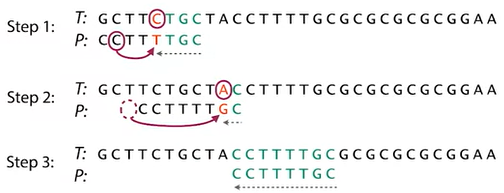

2 situations possible. Either the mismatched character is present in another location of the pattern or the mismatched character is not present in the pattern.

Step1 -> Step2 shows that the algorithm skips 2 iterations because the mismatched character is present in the 3rd position in the pattern.
Step2 -> Step3 shows that the algorithm skips 6 iterations because the mismatched character is not present in the pattern.

__Good Suffix Rule-__

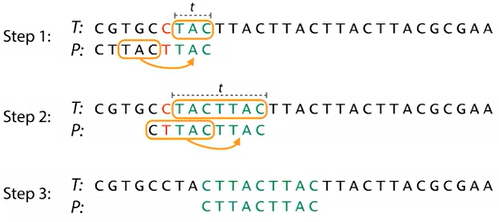

This rule makes the algorithm skip as many iterations as possible while trying to preserve the aldready matched characters. In step 1, the algorithm skips 3 iterations because the matched substring is present in another position in the pattern. Similar result can be seen in step 2.

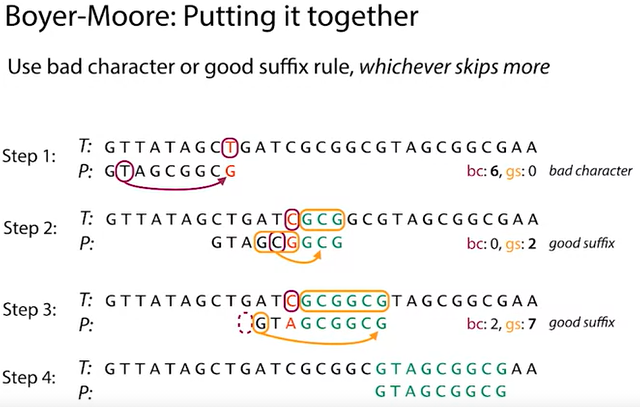

#### Preprocessing

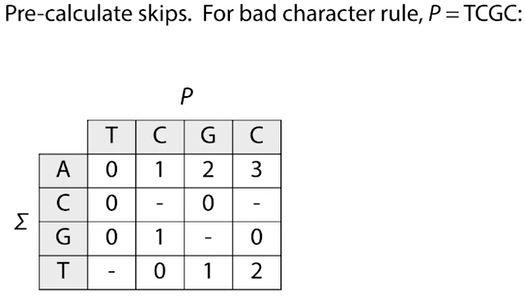

### 1. Practical: Implementing Boyer-Moore Algorithm

In [27]:
# This code has been copied from the class. This code preprocesses the pattern as arrays for both the rules.
import string

def z_array(s):
    """ Use Z algorithm (Gusfield theorem 1.4.1) to preprocess s """
    assert len(s) > 1
    z = [len(s)] + [0] * (len(s)-1)
    # Initial comparison of s[1:] with prefix
    for i in range(1, len(s)):
        if s[i] == s[i-1]:
            z[1] += 1
        else:
            break
    r, l = 0, 0
    if z[1] > 0:
        r, l = z[1], 1
    for k in range(2, len(s)):
        assert z[k] == 0
        if k > r:
            # Case 1
            for i in range(k, len(s)):
                if s[i] == s[i-k]:
                    z[k] += 1
                else:
                    break
            r, l = k + z[k] - 1, k
        else:
            # Case 2
            # Calculate length of beta
            nbeta = r - k + 1
            zkp = z[k - l]
            if nbeta > zkp:
                # Case 2a: Zkp wins
                z[k] = zkp
            else:
                # Case 2b: Compare characters just past r
                nmatch = 0
                for i in range(r+1, len(s)):
                    if s[i] == s[i - k]:
                        nmatch += 1
                    else:
                        break
                l, r = k, r + nmatch
                z[k] = r - k + 1
    return z


def n_array(s):
    """ Compile the N array (Gusfield theorem 2.2.2) from the Z array """
    return z_array(s[::-1])[::-1]


def big_l_prime_array(p, n):
    """ Compile L' array (Gusfield theorem 2.2.2) using p and N array.
        L'[i] = largest index j less than n such that N[j] = |P[i:]| """
    lp = [0] * len(p)
    for j in range(len(p)-1):
        i = len(p) - n[j]
        if i < len(p):
            lp[i] = j + 1
    return lp


def big_l_array(p, lp):
    """ Compile L array (Gusfield theorem 2.2.2) using p and L' array.
        L[i] = largest index j less than n such that N[j] >= |P[i:]| """
    l = [0] * len(p)
    l[1] = lp[1]
    for i in range(2, len(p)):
        l[i] = max(l[i-1], lp[i])
    return l


def small_l_prime_array(n):
    """ Compile lp' array (Gusfield theorem 2.2.4) using N array. """
    small_lp = [0] * len(n)
    for i in range(len(n)):
        if n[i] == i+1:  # prefix matching a suffix
            small_lp[len(n)-i-1] = i+1
    for i in range(len(n)-2, -1, -1):  # "smear" them out to the left
        if small_lp[i] == 0:
            small_lp[i] = small_lp[i+1]
    return small_lp


def good_suffix_table(p):
    """ Return tables needed to apply good suffix rule. """
    n = n_array(p)
    lp = big_l_prime_array(p, n)
    return lp, big_l_array(p, lp), small_l_prime_array(n)


def good_suffix_mismatch(i, big_l_prime, small_l_prime):
    """ Given a mismatch at offset i, and given L/L' and l' arrays,
        return amount to shift as determined by good suffix rule. """
    length = len(big_l_prime)
    assert i < length
    if i == length - 1:
        return 0
    i += 1  # i points to leftmost matching position of P
    if big_l_prime[i] > 0:
        return length - big_l_prime[i]
    return length - small_l_prime[i]


def good_suffix_match(small_l_prime):
    """ Given a full match of P to T, return amount to shift as
        determined by good suffix rule. """
    return len(small_l_prime) - small_l_prime[1]


def dense_bad_char_tab(p, amap):
    """ Given pattern string and list with ordered alphabet characters, create
        and return a dense bad character table.  Table is indexed by offset
        then by character. """
    tab = []
    nxt = [0] * len(amap)
    for i in range(0, len(p)):
        c = p[i]
        assert c in amap
        tab.append(nxt[:])
        nxt[amap[c]] = i+1
    return tab


class BoyerMoore(object):
    """ Encapsulates pattern and associated Boyer-Moore preprocessing. """
    
    def __init__(self, p, alphabet='ACGT'):
        self.p = p
        self.alphabet = alphabet
        # Create map from alphabet characters to integers
        self.amap = {}
        for i in range(len(self.alphabet)):
            self.amap[self.alphabet[i]] = i
        # Make bad character rule table
        self.bad_char = dense_bad_char_tab(p, self.amap)
        # Create good suffix rule table
        _, self.big_l, self.small_l_prime = good_suffix_table(p)
    
    def bad_character_rule(self, i, c):
        """ Return # skips given by bad character rule at offset i """
        assert c in self.amap
        ci = self.amap[c]
        assert i > (self.bad_char[i][ci]-1)
        return i - (self.bad_char[i][ci]-1)
    
    def good_suffix_rule(self, i):
        """ Given a mismatch at offset i, return amount to shift
            as determined by (weak) good suffix rule. """
        length = len(self.big_l)
        assert i < length
        if i == length - 1:
            return 0
        i += 1  # i points to leftmost matching position of P
        if self.big_l[i] > 0:
            return length - self.big_l[i]
        return length - self.small_l_prime[i]
    
    def match_skip(self):
        """ Return amount to shift in case where P matches T """
        return len(self.small_l_prime) - self.small_l_prime[1]

In [3]:
# Checking if the bad character rule algorithm works.
# GCTAGCTCTACGAGTCTA -> Text
p = 'TCAA'
p_bm = BoyerMoore(p, alphabet='ACGT')
p_bm.bad_character_rule(2, 'T') # Checks the array for the closest 'T' from position 2 of the pattern

2

In [8]:
# Checking if the good algorithm rule algorithm works.
# GCTAGCTCTACGAGTCTA
# ACTA
p = 'ACTA'
p_bm = BoyerMoore(p, alphabet='ACGT')
p_bm.good_suffix_rule(0) # Checks the array for the closest substring from position 0 of the pattern.

3

In [9]:
# Algorithm which skips iterations depending on which rule produces the highest skip.
# ACACGCTCTACGAGTCTA
# ACAC
p = 'ACAC'
p_bm = BoyerMoore(p, alphabet='ACGT')
p_bm.match_skip() # In this case, good suffix rule produces the highest skip, i.e, 2.

2

In [28]:
# Creating complete boyer-moore algorithm
def boyer_moore(p, p_bm, t):
    """ Do Boyer-Moore matching """
    i = 0
    occurrences = []
    while i < len(t) - len(p) + 1:
        shift = 1
        mismatched = False
        for j in range(len(p)-1, -1, -1):
            if p[j] != t[i+j]:
                skip_bc = p_bm.bad_character_rule(j, t[i+j])
                skip_gs = p_bm.good_suffix_rule(j)
                shift = max(shift, skip_bc, skip_gs)
                mismatched = True
                break
        if not mismatched:
            occurrences.append(i)
            skip_gs = p_bm.match_skip()
            shift = max(shift, skip_gs)
        i += shift
    return occurrences

In [88]:
t = 'GCTACGATCTAGAATCTA'
p = 'TCTAGAA'
p_bm = BoyerMoore(p, alphabet='ACGT')

In [89]:
boyer_moore(p, p_bm, t)

[7]

In [16]:
t[14:18]

'TCTA'

### 2. Practical: Implementing a k-mer index

kmer: Substring of length k.

There are two methods by which indexing is done-
1. Ordered Structured Indexing
2. Hash Table Indexing

In ordered structured indexing, the pattern is compared to the kmer present in the alphabetically ordered list of all possible kmers. If the pattern is alphabetically lower, then the other half of list is not taken into consideration. This cycle continues until the kmer which is same as pattern is found.

In hash table indexing, a hash table containing all possible kmers is constructed. The has key for the kmer which is the same as pattern is obtained when comparing.

#### Ordered Structured Indexing

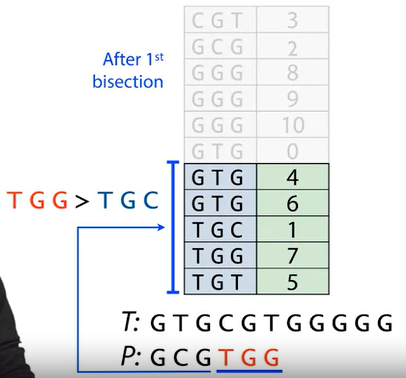

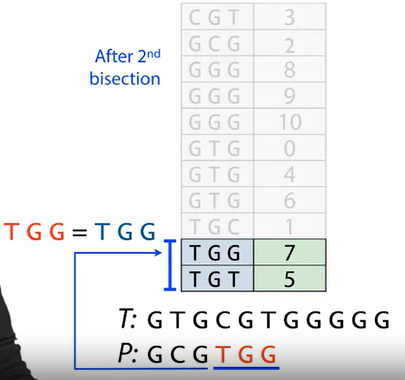



In [29]:
import bisect
# bisect functions take an array as first parameter and value to be inserted as second parameter.
a = [1 , 3 , 3 , 6 , 8 , 8 , 9 , 10]
bisect.bisect_left(a , 9) # Finds the leftmost position such that insertion does not disturb sorted order

6

In [30]:
bisect.bisect_right(a , 9) # Finds the rightmost position such that insertion does not disturb sorted order

7

In [76]:
import bisect
class Index(object):
    
    def __init__(self , t , k):
        self.k = k
        self.index = []
        for i in range(len(t) - k + 1):
            self.index.append((t[i : i+k] , i))
        self.index.sort()
        
    
    def query(self , p):
        offset = []
        kmer = p[:self.k]
        i = bisect.bisect_left(self.index , (kmer,-1))
        while i<len(self.index):
            if self.index[i][0] != kmer:
                break
            offset.append(self.index[i][1])
            i +=1
        return(offset)

In [85]:
def matching(t , p , k):
    preprocess = Index(t , k)
    
    #kmer = p[:k]
    offset = preprocess.query(p)
    final = []
    for i in offset:
        if p == t[i : i + len(p)]:
            final.append(i)
    
    return(offset)

In [87]:
t = 'GCTACGATCTAGAATCTA'
p = 'TCTAGAA'
matching(t , p , 4)

[7, 14]

In [ ]:
# t = Chromosome 1
# p = GGCGCGGTGGCTCACGCCTGTAAT
# k = 8
# d = 2

def index_pidgeon(t = str , p = str , k = int , d = int):
    match = [] # Brackets for 'p'
    
    t_preprocess = Index(t , k) # Gets the Ordered Index for 't'
    p_brac_size = math.ceil(len(p)/(d+1)) # Finds the size of each bracket of 'p'
    
    for i in range(0 , len(p) , size): # Separating 'p' into brackets
        match.append(p[i : i+size])

In [81]:
def intro(t = str , k = int):
    size = len(t)/k
    
    return(size)

In [82]:
t = 'AUJFEI'
k = 2
intro(t , k)

3.0

#### Hash Table

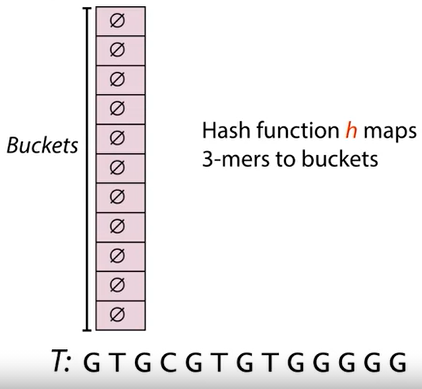

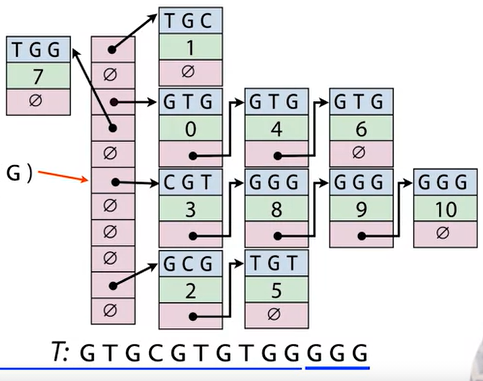

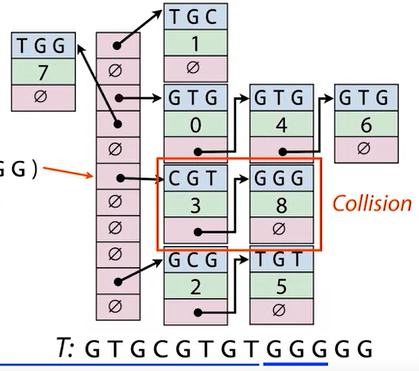

### Variations on K-mer indexing

2 different variations-
1. Removal of x amount of indexed kmers-
2. SubSequence of Sequence

### Pidgeonhole Principle - 

Converting Perfect match algorithm to approximate match algorithm

In [98]:
import math
# Converting the exact algorithm Boyer-Moore Algorithm to approximate matching algorithm using pidgeonhole principle
def boyer_pidgeon(p , t , d):
    final_pos = []
    size = math.ceil(len(p)/(d+1))
    match = []
    index_hits = 0
    
    for i in range(0 , len(p) , size): # Separating p into brackets
        match.append(p[i : i+size])
    
    for m in range(len(match)):
        prev_brac = ''.join(match[0 : m]) # Creating str from pos 0 of p to starting pos of match
        brac = match[m]
        forw_brac = ''.join(match[m+1 : len(match)]) # Creating str from pos of match to end of p
        
        
        m_bm = BoyerMoore(brac , alphabet = 'AGCT') # Preprocessing of bracket
        boyer_match = boyer_moore(brac , m_bm , t) # Finding the bracket in 't' using Boyer-Moore Algorithm
        index_hits += len(boyer_match)
        
        
        for j in boyer_match:
            count = 0
            if len(prev_brac) == 0: # Checking if there is a string behind the matched position
                pass
            else:
                prev_match = t[j-len(prev_brac) : j] 
                for k in range(len(prev_brac)): # Checking the no. of dissimilarities between the bracket and text in the back
                    if prev_brac[k] != prev_match[k]:
                        count += 1
                    if count > d:
                        break
                
            if len(forw_brac) == 0: # Checking if there is a string ahead of the matched position
                pass
            else:
                forw_match = t[j+size : j+size+len(forw_brac)]
                for k in range(len(forw_brac)): # Checking the no. of disimilarities between the bracket and text in the front
                    if forw_brac[k] != forw_match[k]:
                        count += 1
                    if count > d:
                        break
            
            if count <= d:
                if m == 0:
                    final_pos.append(j)
                else:
                    final_pos.append(j-len(prev_brac))
    
    final_pos = list(set(final_pos))
    

    print(final_pos,index_hits)

In [99]:
p = 'AACTTG'
t = 'CACTTAATTTG'
boyer_pidgeon(p , t , 2)
#p_bm = BoyerMoore(p, alphabet='ACGT')

[0, 5] 3


### Programming Homework

To compare the naive matching algorithm & the Boyer-Moore Agorithm

#### Naive Matching Algorithm

In [3]:
# Creating the naive matching algorithm
def naive(t , p):
    match_offset = []
    total_char_comparison = 0
    total_line_comparison = 0
    
    for i in range(len(t) - len(p) + 1):
        for j in range(len(p)):
            match = True
            if p[j] != t[i + j]:
                match = False
                break
        total_char_comparison += (j + 1)
        
        if match:
            match_offset.append(i)
        total_line_comparison += 1
        
    return(match_offset , total_line_comparison,
           total_char_comparison)

In [6]:
t = 'needle need noodle needle'
p = 'needle'
print(naive(t , p))

([0, 19], 20, 35)


#### Boyer-Moore Algorithm

In [4]:
# Creating the Boyer-Moore Preprocessing Algorithm was not taught in the course as it was deemed to be 
# very complex for beginners.
# The python file written by Mr. Ben Langmead (course instructor) was downloaded which contained the preprocessing
# algorithm
from bm_preproc import BoyerMoore

In [5]:
# The Boyer-Moore Algorithm
def boyer_moore(p, p_bm, t):
    """ Do Boyer-Moore matching. p=pattern, t=text,
        p_bm=BoyerMoore object for p """
    total_char_comparison = 0
    total_line_comparison = 0
    i = 0
    occurrences = []
    while i < len(t) - len(p) + 1:
        shift = 1
        mismatched = False
        for j in range(len(p)-1, -1, -1):
            total_char_comparison += 1
            if p[j] != t[i+j]:
                skip_bc = p_bm.bad_character_rule(j, t[i+j])
                skip_gs = p_bm.good_suffix_rule(j)
                shift = max(shift, skip_bc, skip_gs)
                mismatched = True
                break
        if not mismatched:
            occurrences.append(i)
            skip_gs = p_bm.match_skip()
            shift = max(shift, skip_gs)
        i += shift
        total_line_comparison += 1
    return (occurrences , total_line_comparison , total_char_comparison)

In [9]:
p = 'word'
t = 'there would have been a time for such a word'
lowercase_alphabet = 'abcdefghijklmnopqrstuvwxyz '
p_bm = BoyerMoore(p, lowercase_alphabet)
occurrences, num_alignments, num_character_comparisons = boyer_moore(p, p_bm, t)
print(occurrences, num_alignments, num_character_comparisons)

[40] 12 15


#### Programming Questions

In [92]:
def read_genome(filename):
    # Opening the file
    with open(filename , 'r') as gene_file:
        gene = gene_file.readlines()
        
        # First line contains basic information about the genome in the file
        # This line is to be omitted
        gene = gene[1:]
        
        # For loop for removing newline(\n) from the file
        for i in range(len(gene)):
            gene[i] = gene[i].replace('\n' , '')
        
        # Concatenating the file which is in the form of a list right now
        gene = ''.join(gene)
    return(gene)

In [93]:
t = read_genome('chr1.GRCh38.excerpt.fasta')

##### Question 1
How many alignments does the naive exact matching algorithm try when matching the string __GGCGCGGTGGCTCACGCCTGTAATCCCAGCACTTTGGGAGGCCGAGG__ (derived from human Alu sequences) to the excerpt of human chromosome 1?  (Don't consider reverse complements.)

In [15]:
p = 'GGCGCGGTGGCTCACGCCTGTAATCCCAGCACTTTGGGAGGCCGAGG'
print(naive(t , p))

([56922], 799954, 984143)


##### Question 2
How many character comparisons does the naive exact matching algorithm try when matching the string __GGCGCGGTGGCTCACGCCTGTAATCCCAGCACTTTGGGAGGCCGAGG__ (derived from human Alu sequences) to the excerpt of human chromosome 1?  (Don't consider reverse complements.)

In [16]:
p = 'GGCGCGGTGGCTCACGCCTGTAATCCCAGCACTTTGGGAGGCCGAGG'
print(naive(t , p))

([56922], 799954, 984143)


##### Question 3
How many alignments does Boyer-Moore try when matching the string __GGCGCGGTGGCTCACGCCTGTAATCCCAGCACTTTGGGAGGCCGAGG__ (derived from human Alu sequences) to the excerpt of human chromosome 1?  (Don't consider reverse complements.)

In [17]:
p = 'GGCGCGGTGGCTCACGCCTGTAATCCCAGCACTTTGGGAGGCCGAGG'
nucleotide = 'ATGC'
p_bm = BoyerMoore(p, nucleotide)
occurrences, num_alignments, num_character_comparisons = boyer_moore(p, p_bm, t)
print(occurrences, num_alignments, num_character_comparisons)

[56922] 127974 165191


##### Question 4
How many times does the string __GGCGCGGTGGCTCACGCCTGTAAT__, which is derived from a human Alu sequence, occur with up to 2 substitutions in the excerpt of human chromosome 1?  

In [97]:
t = read_genome('chr1.GRCh38.excerpt.fasta')
p = 'GGCGCGGTGGCTCACGCCTGTAAT'
d = 2
x = boyer_pidgeon(p , t , d)

[273669, 681737, 717706, 262042, 635931, 84641, 160162, 724927, 657496, 160729, 56922, 191452, 551134, 747359, 421221, 147558, 364263, 465647, 429299]


##### Question 5
Using the instructions given in Question 4, how many total index hits are there when searching for occurrences of __GGCGCGGTGGCTCACGCCTGTAAT__ with up to 2 substitutions in the excerpt of human chromosome 1?

Hint: You should be able to use the __boyer_moore__ function (or the slower __naive__ function) to double-check your answer.

In [100]:
t = read_genome('chr1.GRCh38.excerpt.fasta')
p = 'GGCGCGGTGGCTCACGCCTGTAAT'
d = 2
x = boyer_pidgeon(p , t , d)

[273669, 681737, 717706, 262042, 635931, 84641, 160162, 724927, 657496, 160729, 56922, 191452, 551134, 747359, 421221, 147558, 364263, 465647, 429299] 90


##### Question 6
Let's examine whether there is a benefit to using an index built using subsequences of T rather than substrings, as we discussed in the "Variations on k-mer indexes" video.  We'll consider subsequences involving every N characters.  For example, if we split __ATATAT__ into two substring partitions, we would get partitions __ATA__ (the first half) and __TAT__ (second half).  But if we split __ATATAT__ into two  subsequences  by taking every other character, we would get __AAA__ (first, third and fifth characters) and __TTT__ (second, fourth and sixth).

Another way to visualize this is using numbers to show how each character of P is allocated to a partition.  Splitting a length-6 pattern into two substrings could be represented as __111222__, and splitting into two subsequences of every other character could be represented as __121212__

Write a function that, given a length-24 pattern P and given a __SubseqIndex object__ built with k = 8 and ival = 3, finds all approximate occurrences of P within T with up to 2 mismatches.

When using this function, how many total index hits are there when searching for __GGCGCGGTGGCTCACGCCTGTAAT__ with up to 2 substitutions in the excerpt of human chromosome 1?  (Again, don't consider reverse complements.)